# My first NLP project
## Sentiment analysis using a DNN model

## Task

The objective of sentiment analysis is to define the polarity of a sentence. For example in movie' s review the objective is to define the overall user satisfaction whether it is positive or negative. Here, we will not focus on aspect based sentiment analysis (polarity for specific aspects e.g actors, scenario, costume) but we will focus on a simple classification task of positive and negative polarity. 

We will train a model to predict for the polarity of a given sentence/paragraph. The input will be text and the output will be the positive or negative class. 

To perform this task we need data. Download and store your data under the data folder on the "Colabnotebooks" folder you have created for the project. 

The dataset is called aclImdb and contains movie reviews from a well known benchmark. The folder contains the training, test and validation data. 

We will 
1. build a simple DNN model
2. train the model 
3. evaluate the model' s accuracy 

The architectures we will use are a simple DNN architecture with and without embeddings


## Prepare data
You need to mount your google drive to be able to read and write on the drive. 
During the reading operation the data will be read by the code and after training model will be stored under data/models folder. So make sure you create the folder in advance. To mount the drive just follow the instructions (go to url, choose the email account linked to this notebook and copy paste the url link in the window that appears below). 

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
# set seed for replicability of results
import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
!ls

In [ ]:
%cd gdrive/MyDrive/Colab/

In [ ]:
!ls


In [ ]:
!git clone https://github.com/mkoutsog/uoc_nlp_lectures.git

#Sentiment analysis using a Multi-layer Perceptron 

Before we start we need to create a function that reads the data. 
For training the network to recognise sentiments we need first to give 
BOTH text and class that is 
- the review of the user in text
- the polarity negative/positive if the text speaks negatively/positively about a movie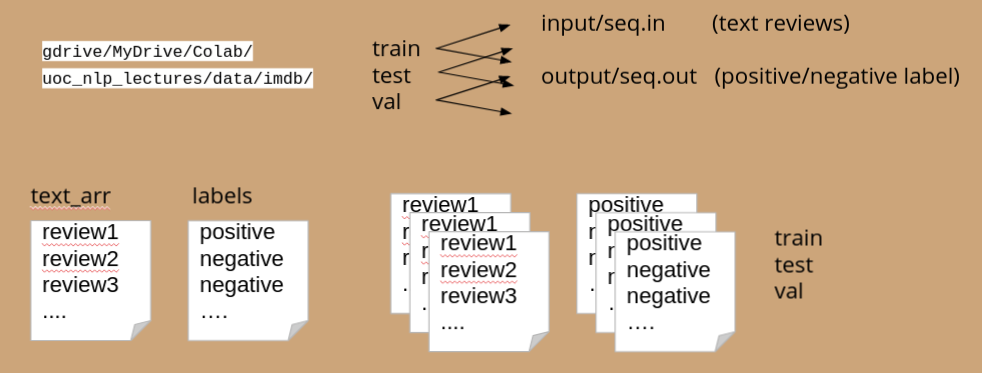 

The functon below reads from the path the imdb data. 
The imdb folder contains the test, train and val folders for the training, testing and validation of our model. All texts are loaded in a text_arr list and the corresponding labels (positive or negative) in the labels list

In [13]:
import os

def read_data(dataset_path, mode):
  # dataset_path = 'uoc_nlp_lectures/data/imdb/'
  # mode = train or test or val
  dataset_folder_path = dataset_path+mode  # e.g for mode train: 'uoc_nlp_lectures/data/imdb/train/'
  print(dataset_folder_path)
  
  with open(os.path.join(dataset_folder_path, 'output/seq.out'), encoding='utf-8') as f:
    labels = []
    labels_tmp = f.readlines()
    for i in labels_tmp:
      labels.append(i.strip())

  with open(os.path.join(dataset_folder_path, 'input/seq.in'), encoding='utf-8') as f:
    text_arr_tmp = f.readlines()
    text_arr = []
    for i in text_arr_tmp:
      text_arr.append(i.strip())
  return text_arr, labels


dataset_path = 'uoc_nlp_lectures/data/imdb/'

train_arr, train_labels = read_data(dataset_path, "train")
test_arr, test_labels = read_data(dataset_path, "test")
val_arr, val_labels = read_data(dataset_path, "val")

uoc_nlp_lectures/data/imdb/train
uoc_nlp_lectures/data/imdb/test
uoc_nlp_lectures/data/imdb/val


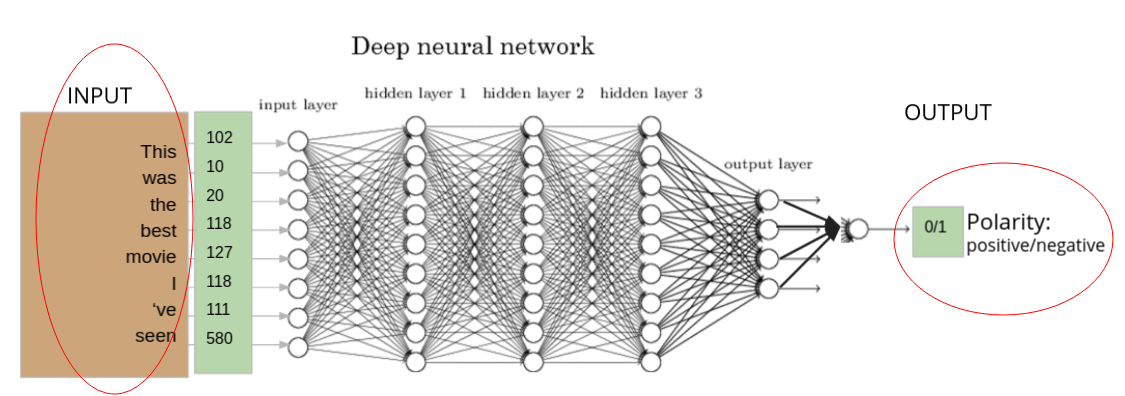

We now need to tokenize our text! 

1. construct a vocabulary from our text by assigning randomly integers for each word 
2. tokenize our text that is create an one-hot encoding representation before we pass it to the embedding layer

In [39]:
from tensorflow.keras.preprocessing import text, sequence

In [50]:
# set our vocabulary size. We may have more words than 5000 but these 5000 will be the most relevant for the classification
vocabulary_size = 5000
input_length = 2048

# Create a tokenizer
tokenizer = text.Tokenizer(num_words=vocabulary_size)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# We fit this tokenizer to our data 
tokenizer.fit_on_texts(train_arr) # Create word index using only training part
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 0 unique tokens.
Found 88565 unique tokens.


In [51]:
# Vectorize texts 
x_train = tokenizer.texts_to_matrix(train_arr, mode="binary")
x_test = tokenizer.texts_to_matrix(test_arr, mode='binary')
x_val = tokenizer.texts_to_matrix(val_arr, mode='binary')

For the first text val_arr[0] lets print the vector that shows the vocabulary sequence

In [ ]:
for index, i in enumerate(x_val[0]):
  tt = tokenizer.sequences_to_texts([[index]])
  if i!=0:
    print(tt)



Note that function words e.g the, and, was etc. appear in the first columns of the table. We can exploit this and reduce the vocabulary by taking the last columns (the function pad_sequences trunkates the matrix by removing the fist columns) e.g [6 0 1], [0 2 3], [4,5,6] --> [0 1], [2 3], [5 6] if maxlen=2

In [55]:
X_train = sequence.pad_sequences(x_train, maxlen=input_length)
X_test = sequence.pad_sequences(x_test, maxlen=input_length)
X_val = sequence.pad_sequences(x_val, maxlen=input_length)

In [ ]:
for index, i in enumerate(X_val[0]):
  tt = tokenizer.sequences_to_texts([[index]])
  if i!=0:
    print(tt)

In [32]:
import numpy as np
words_test = ['I', 'boring', 'glikanissos']
sequences = tokenizer.texts_to_matrix(words_test, mode="count")
print("print the I : ", sequences[0])
print("print the glikanissos : ", sequences[2])
print(np.max(sequences[0]), np.max(sequences[1]), np.max(sequences[2]))

print the I :  [0. 0. 0. ... 0. 0. 0.]
print the glikanissos :  [0. 0. 0. ... 0. 0. 0.]
1.0 1.0 0.0


Considering that the binary encoding does not give you information regarding which words may be important for text classification, use the tfidf encoding and test it in the same data. What do you see? 

In [ ]:
# Write your code here 

We are not finished yet! Remember from the previous figure we need to vectorize the labels as well (negative / positive)

In [57]:
from sklearn.preprocessing import LabelEncoder
vectorizer = LabelEncoder()
vectorizer.fit(["positive", "negative"])
# Vectorize texts into one-hot encoding representations
y_train = vectorizer.transform(train_labels)
y_test = vectorizer.transform(test_labels) 
y_val = vectorizer.transform(val_labels) 

We have finished with the vectorization!!
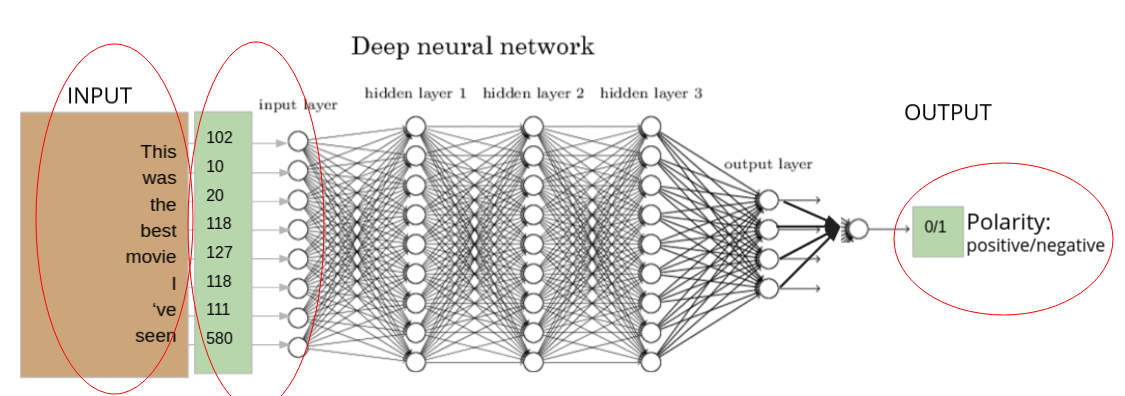

Lets now create our model!!


The model will consist as we said of an Embedding layer followed by a Multi-layer Perceptron which consists of an imput, output and at least one hidden layer with non linear activations 

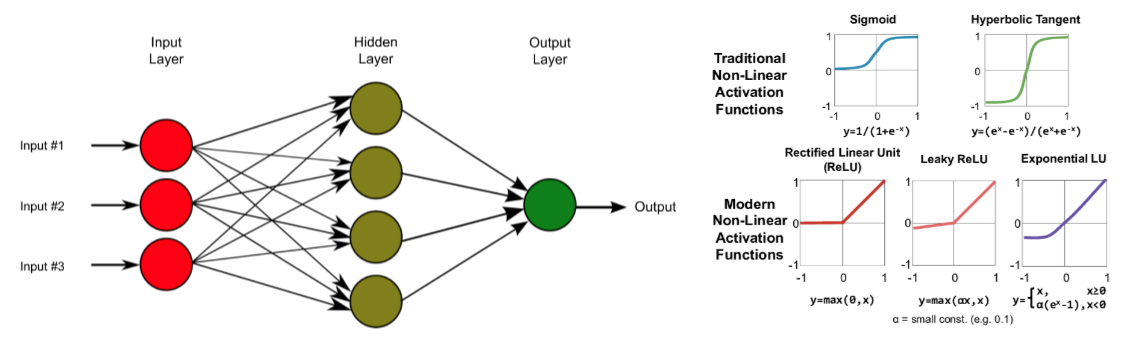

But before lets create a simpler network that has no embedding. It will take as input our text vectorized, it will have one hidden layer and then it will output the class. 

In [60]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
model = Sequential() # appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model.add(Dense(512, activation='relu', input_shape=(input_length,)))
model.add(Dense(1, activation='sigmoid'))
# define the optimization function 
optim = Adam(learning_rate=0.0001)

# the loss function 
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy']) #  loss for binary (0 or 1) classification applications

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
              epochs=3, batch_size=16, verbose=1)

model.summary()

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Lets add an embedding layer before 

In [67]:

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers.embeddings import Embedding

In [ ]:
# setup a MLP network
model = Sequential() # appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor

# the input of the embedding layer will be the size of the tensor x_val that is 2048 words for each text sequence
# we will represent each word with a 128 vector 
# and the index of each word is betwen [0-5000]
model.add(Embedding(vocabulary_size, 128, input_length=input_length)) 
model.add(Flatten())
model.add(Dense(512, activation='relu', input_shape=(input_length,)))
model.add(Dense(1, activation='sigmoid'))

# define the optimization function 
optim = Adam(learning_rate=0.0001)

# the loss function 
model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy']) #  loss for binary (0 or 1) classification applications

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
              epochs=3, batch_size=16, verbose=1)

model.summary()

Epoch 1/3
1382/1563 [=========================>....] - ETA: 1:58 - loss: 0.6587 - accuracy: 0.6032

782/782 [==============================] - 8s 10ms/step - loss: 0.5854 - accuracy: 0.6884
Accuracy: 68.84%

Execution Time 1277.0433337688446 seconds: 


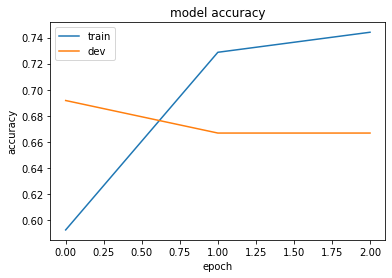

In [183]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

Try different improvements in the code

In [ ]:
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

# add L1, L2  or L2_L2 weight regularization to youd hidden layer
regularizer = regularizers.l1_l2(0.001, 0.001)

# add a dropout layer 

# what is the relationship between your parameters and the size of the network

# perform vectorization using TFIDF method
